<a href="https://colab.research.google.com/github/prachi735/EVA4.0/blob/master/session6/EVA4_S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from pdb import set_trace as bp

# Transformations

In [0]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       #transforms.RandomAffine((-5.0,5.0),fillcolor=1),
                                       #transforms.RandomPerspective(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Load dataset

In [0]:
train = datasets.MNIST('./data', train=True, download=True,transform=train_transforms)
test = datasets.MNIST('./data', train=True, download=True,transform=test_transforms)

# Dataloaders: Test/Train dataset

In [4]:
SEED = 3

# is cuda available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4,pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, ** dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Basic Model

In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 26 output_size = 24 receptive_field = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 24 output_size = 22 receptive_field = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 22 output_size = 11 receptive_field = 9
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 11 output_size = 11 receptive_field = 9

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 11 output_size = 9 receptive_field = 13
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 9 output_size = 7 receptive_field = 17
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 7 output_size = 5 receptive_field = 21
        # OUTPUT BLOCK
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5, 5), padding=0, bias=False),
        ) # input_size = 5 output_size = 1  receptive_field = 29
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [6]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1

#Training & Testing

In [0]:
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch, l1_reg=False, l1_lambda=0):
  #bp()
  train_epoch_acc = []
  train_epoch_loss = []
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    if l1_reg:
       
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0
        for param in model.parameters():
            zero_tensor = torch.zeros(param.size()).to(device)
            reg_loss += l1_crit(param, zero_tensor)

        
        loss += l1_lambda * reg_loss

    # Backpropagation
    loss.backward()
    train_epoch_loss.append(loss.item())
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_epoch_acc.append(100*correct/processed)

  return train_epoch_acc, train_epoch_loss

def test(model, device, test_loader, 
         return_misclassified=False, 
         number_of_images_to_return=0, 
         return_worst_predictions=False):

    misclassified_images_list = []
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_value = torch.max(output, dim=1).values

            match_tensor = pred.eq(target.view_as(pred))
            misclassified_images_in_batch = torch.where(match_tensor == False)
            for eachimage in misclassified_images_in_batch[0]:
               image_predlist = [data[eachimage], pred[eachimage].item(), pred_value[eachimage].item(), target[eachimage].item()]
               misclassified_images_list.append(image_predlist)
            correct += match_tensor.sum().item()

    test_loss /= len(test_loader.dataset)
    

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc = 100. * correct / len(test_loader.dataset)
    #bp()
    if return_misclassified:
      if not return_worst_predictions:
        return test_acc, test_loss, misclassified_images_list[:number_of_images_to_return]
      else:
        sorted_on_pred_value = sorted(misclassified_images_list, key = lambda x: x[2], reverse=True)
        return test_acc, test_loss, sorted_on_pred_value[:number_of_images_to_return]
    
    return test_acc, test_loss

# Train & Test model

In [8]:
train_acc_no_reg = []
train_losses_no_reg = []
test_acc_no_reg = []
test_losses_no_reg = []
model_no_reg =  Net().to(device)
optimizer = optim.SGD(model_no_reg.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch_acc_no_reg, train_epoch_losses_no_reg = train(model_no_reg, device, train_loader, optimizer, epoch)
    train_acc_no_reg.extend(train_epoch_acc_no_reg)
    train_losses_no_reg.extend(train_epoch_losses_no_reg)

    test_acc_no_reg_epoch, test_losses_no_reg_epoch = test(model_no_reg, device, test_loader)
    test_acc_no_reg.append(test_acc_no_reg_epoch)
    test_losses_no_reg.append(test_losses_no_reg_epoch)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.0749192014336586 Batch_id=468 Accuracy=92.97: 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0734, Accuracy: 58610/60000 (97.68%)

EPOCH: 1


Loss=0.07778843492269516 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:14<00:00, 33.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 59083/60000 (98.47%)

EPOCH: 2


Loss=0.04632866010069847 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:13<00:00, 33.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 59265/60000 (98.78%)

EPOCH: 3


Loss=0.08766346424818039 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 59265/60000 (98.78%)

EPOCH: 4


Loss=0.02130710519850254 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:13<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 59318/60000 (98.86%)

EPOCH: 5


Loss=0.032806191593408585 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:13<00:00, 33.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 59371/60000 (98.95%)

EPOCH: 6


Loss=0.08068608492612839 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:13<00:00, 39.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 59480/60000 (99.13%)

EPOCH: 7


Loss=0.1094377338886261 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 34.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 59442/60000 (99.07%)

EPOCH: 8


Loss=0.04496454820036888 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 59431/60000 (99.05%)

EPOCH: 9


Loss=0.017900893464684486 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 33.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 59515/60000 (99.19%)

EPOCH: 10


Loss=0.16801296174526215 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 59527/60000 (99.21%)

EPOCH: 11


Loss=0.11904475837945938 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 35.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 59495/60000 (99.16%)

EPOCH: 12


Loss=0.0759294405579567 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 35.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 59622/60000 (99.37%)

EPOCH: 13


Loss=0.02651745080947876 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 34.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 59608/60000 (99.35%)

EPOCH: 14


Loss=0.04000532999634743 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 59639/60000 (99.40%)

EPOCH: 15


Loss=0.015756214037537575 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 34.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 59579/60000 (99.30%)

EPOCH: 16


Loss=0.009617328643798828 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 59677/60000 (99.46%)

EPOCH: 17


Loss=0.17808882892131805 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 59683/60000 (99.47%)

EPOCH: 18


Loss=0.04546798765659332 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 59671/60000 (99.45%)

EPOCH: 19


Loss=0.05135070160031319 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 34.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 59694/60000 (99.49%)

EPOCH: 20


Loss=0.029834965243935585 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 59670/60000 (99.45%)

EPOCH: 21


Loss=0.05839772894978523 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 59707/60000 (99.51%)

EPOCH: 22


Loss=0.02688140608370304 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 39.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 59702/60000 (99.50%)

EPOCH: 23


Loss=0.005935803055763245 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 35.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 59707/60000 (99.51%)

EPOCH: 24


Loss=0.00304345297627151 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 35.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 59682/60000 (99.47%)

EPOCH: 25


Loss=0.010777409188449383 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 59752/60000 (99.59%)

EPOCH: 26


Loss=0.006688395980745554 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 36.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 59704/60000 (99.51%)

EPOCH: 27


Loss=0.0599890761077404 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 36.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 59744/60000 (99.57%)

EPOCH: 28


Loss=0.005796690937131643 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 36.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 59773/60000 (99.62%)

EPOCH: 29


Loss=0.013853952288627625 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 35.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 59734/60000 (99.56%)

EPOCH: 30


Loss=0.0037043143529444933 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 59749/60000 (99.58%)

EPOCH: 31


Loss=0.04900212585926056 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 36.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 59764/60000 (99.61%)

EPOCH: 32


Loss=0.0026439924258738756 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 36.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 59774/60000 (99.62%)

EPOCH: 33


Loss=0.04499010369181633 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 35.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0129, Accuracy: 59763/60000 (99.61%)

EPOCH: 34


Loss=0.021151140332221985 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 35.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 59755/60000 (99.59%)

EPOCH: 35


Loss=0.0011010667076334357 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 36.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 59786/60000 (99.64%)

EPOCH: 36


Loss=0.04658922553062439 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 59797/60000 (99.66%)

EPOCH: 37


Loss=0.007111658807843924 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 59784/60000 (99.64%)

EPOCH: 38


Loss=0.01011184323579073 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 35.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 59803/60000 (99.67%)

EPOCH: 39


Loss=0.04859413579106331 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 34.22it/s]



Test set: Average loss: 0.0120, Accuracy: 59786/60000 (99.64%)



In [9]:
train_acc_l1 = []
train_losses_l1 = []
test_acc_l1 = []
test_losses_l1 = []

model_l1 =  Net().to(device)
optimizer = optim.SGD(model_l1.parameters(), lr=0.01, momentum=0.9)
misclassified_dict_args = dict(return_misclassified = True, 
                          number_of_images_to_return=25,
                          return_worst_predictions=True)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch_acc_l1, train_epoch_losses_l1 = train(model_l1, device, train_loader, optimizer, epoch, l1_reg=True, l1_lambda=0.0005)
    train_acc_l1.extend(train_epoch_acc_l1)
    train_losses_l1.extend(train_epoch_losses_l1)

    if epoch == EPOCHS-1:
        test_acc_l1_epoch, test_losses_l1_epoch, misclassified_list_l1 = test(model_l1, device, test_loader, ** misclassified_dict_args)
    else:    
        test_acc_l1_epoch, test_losses_l1_epoch = test(model_l1, device, test_loader)

    test_acc_l1.append(test_acc_l1_epoch)
    test_losses_l1.append(test_losses_l1_epoch)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.3165193498134613 Batch_id=468 Accuracy=92.43: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0792, Accuracy: 58560/60000 (97.60%)

EPOCH: 1


Loss=0.2662087082862854 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:15<00:00, 30.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0696, Accuracy: 58725/60000 (97.88%)

EPOCH: 2


Loss=0.18801933526992798 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 59062/60000 (98.44%)

EPOCH: 3


Loss=0.21409906446933746 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:14<00:00, 37.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 59020/60000 (98.37%)

EPOCH: 4


Loss=0.31248313188552856 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:15<00:00, 29.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0627, Accuracy: 58849/60000 (98.08%)

EPOCH: 5


Loss=0.20382431149482727 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:15<00:00, 31.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 59134/60000 (98.56%)

EPOCH: 6


Loss=0.2720094919204712 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:14<00:00, 31.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 59112/60000 (98.52%)

EPOCH: 7


Loss=0.2543986737728119 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 59168/60000 (98.61%)

EPOCH: 8


Loss=0.16134560108184814 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:15<00:00, 39.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 59149/60000 (98.58%)

EPOCH: 9


Loss=0.2745347023010254 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 59160/60000 (98.60%)

EPOCH: 10


Loss=0.19671893119812012 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 59146/60000 (98.58%)

EPOCH: 11


Loss=0.1903328001499176 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:14<00:00, 38.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 59191/60000 (98.65%)

EPOCH: 12


Loss=0.20844605565071106 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:14<00:00, 31.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 59195/60000 (98.66%)

EPOCH: 13


Loss=0.15560263395309448 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:14<00:00, 31.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 59097/60000 (98.50%)

EPOCH: 14


Loss=0.1824895739555359 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 58997/60000 (98.33%)

EPOCH: 15


Loss=0.23908840119838715 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:14<00:00, 38.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 59096/60000 (98.49%)

EPOCH: 16


Loss=0.23798203468322754 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 30.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 59355/60000 (98.92%)

EPOCH: 17


Loss=0.19709016382694244 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 59101/60000 (98.50%)

EPOCH: 18


Loss=0.13627761602401733 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 30.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 59193/60000 (98.66%)

EPOCH: 19


Loss=0.17099568247795105 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 37.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 59314/60000 (98.86%)

EPOCH: 20


Loss=0.17909353971481323 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 31.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 59245/60000 (98.74%)

EPOCH: 21


Loss=0.19784288108348846 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 59317/60000 (98.86%)

EPOCH: 22


Loss=0.17617961764335632 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 32.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 59151/60000 (98.58%)

EPOCH: 23


Loss=0.1879068911075592 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 59141/60000 (98.57%)

EPOCH: 24


Loss=0.2002336084842682 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 59272/60000 (98.79%)

EPOCH: 25


Loss=0.15546582639217377 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 59256/60000 (98.76%)

EPOCH: 26


Loss=0.14031027257442474 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 31.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 59160/60000 (98.60%)

EPOCH: 27


Loss=0.1689298450946808 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 59190/60000 (98.65%)

EPOCH: 28


Loss=0.19229865074157715 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:14<00:00, 33.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 59064/60000 (98.44%)

EPOCH: 29


Loss=0.15916918218135834 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:15<00:00, 31.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 59353/60000 (98.92%)

EPOCH: 30


Loss=0.1869506537914276 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:14<00:00, 31.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 59232/60000 (98.72%)

EPOCH: 31


Loss=0.1609705239534378 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 59304/60000 (98.84%)

EPOCH: 32


Loss=0.15086860954761505 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 37.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 59320/60000 (98.87%)

EPOCH: 33


Loss=0.12503951787948608 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 59050/60000 (98.42%)

EPOCH: 34


Loss=0.13194771111011505 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 59286/60000 (98.81%)

EPOCH: 35


Loss=0.1598232388496399 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 59260/60000 (98.77%)

EPOCH: 36


Loss=0.151333287358284 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 30.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 58972/60000 (98.29%)

EPOCH: 37


Loss=0.1330753117799759 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:14<00:00, 39.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 59220/60000 (98.70%)

EPOCH: 38


Loss=0.19134438037872314 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 59277/60000 (98.80%)

EPOCH: 39


Loss=0.18306207656860352 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:14<00:00, 32.24it/s]



Test set: Average loss: 0.0688, Accuracy: 58728/60000 (97.88%)



In [10]:
train_acc_l2 = []
train_losses_l2 = []
test_acc_l2 = []
test_losses_l2 = []

model_l2 =  Net().to(device)
optimizer = optim.SGD(model_l2.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
misclassified_dict_args = dict(return_misclassified = True, 
                          number_of_images_to_return=25,
                          return_worst_predictions=True)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch_acc_l2, train_epoch_losses_l2 = train(model_l2, device, train_loader, optimizer, epoch)
    train_acc_l2.extend(train_epoch_acc_l2)
    train_losses_l2.extend(train_epoch_losses_l2)

    if epoch == EPOCHS-1:
        test_acc_l2_epoch, test_losses_l2_epoch, misclassified_list_l2 = test(model_l1, device, test_loader, ** misclassified_dict_args)
    else:    
        test_acc_l2_epoch, test_losses_l2_epoch = test(model_l2, device, test_loader)

    test_acc_l2.append(test_acc_l2_epoch)
    test_losses_l2.append(test_losses_l2_epoch)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.06707144528627396 Batch_id=468 Accuracy=92.64: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 58878/60000 (98.13%)

EPOCH: 1


Loss=0.06313636153936386 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 58926/60000 (98.21%)

EPOCH: 2


Loss=0.05265074968338013 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:13<00:00, 44.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 59116/60000 (98.53%)

EPOCH: 3


Loss=0.04950103536248207 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:12<00:00, 36.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 59267/60000 (98.78%)

EPOCH: 4


Loss=0.08007436245679855 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:12<00:00, 36.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 59394/60000 (98.99%)

EPOCH: 5


Loss=0.021533319726586342 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:13<00:00, 36.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 59390/60000 (98.98%)

EPOCH: 6


Loss=0.026568127796053886 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:12<00:00, 43.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 59495/60000 (99.16%)

EPOCH: 7


Loss=0.12176895886659622 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:13<00:00, 35.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 59511/60000 (99.19%)

EPOCH: 8


Loss=0.04322151839733124 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:12<00:00, 44.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 59550/60000 (99.25%)

EPOCH: 9


Loss=0.021523913368582726 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:12<00:00, 36.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 59523/60000 (99.20%)

EPOCH: 10


Loss=0.005711734294891357 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:12<00:00, 42.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 59567/60000 (99.28%)

EPOCH: 11


Loss=0.03331148251891136 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 41.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 59535/60000 (99.22%)

EPOCH: 12


Loss=0.03519083559513092 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:12<00:00, 36.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 59576/60000 (99.29%)

EPOCH: 13


Loss=0.011919130571186543 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:12<00:00, 36.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 59597/60000 (99.33%)

EPOCH: 14


Loss=0.03175612911581993 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:12<00:00, 42.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 59583/60000 (99.31%)

EPOCH: 15


Loss=0.023592064157128334 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 35.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 59549/60000 (99.25%)

EPOCH: 16


Loss=0.06956197321414948 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 36.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 59616/60000 (99.36%)

EPOCH: 17


Loss=0.14463311433792114 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 35.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 59606/60000 (99.34%)

EPOCH: 18


Loss=0.01040901243686676 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 59650/60000 (99.42%)

EPOCH: 19


Loss=0.03066573478281498 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 59604/60000 (99.34%)

EPOCH: 20


Loss=0.05722402408719063 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 34.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 59651/60000 (99.42%)

EPOCH: 21


Loss=0.014411966316401958 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 35.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 59637/60000 (99.39%)

EPOCH: 22


Loss=0.02766953967511654 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 59620/60000 (99.37%)

EPOCH: 23


Loss=0.010612140409648418 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 33.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 59610/60000 (99.35%)

EPOCH: 24


Loss=0.04242844507098198 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 59598/60000 (99.33%)

EPOCH: 25


Loss=0.0081979064270854 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 34.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 59675/60000 (99.46%)

EPOCH: 26


Loss=0.019950002431869507 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 41.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 59618/60000 (99.36%)

EPOCH: 27


Loss=0.012945975176990032 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 59735/60000 (99.56%)

EPOCH: 28


Loss=0.054241497069597244 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 35.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 59700/60000 (99.50%)

EPOCH: 29


Loss=0.026646330952644348 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 59693/60000 (99.49%)

EPOCH: 30


Loss=0.03324664756655693 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:12<00:00, 36.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 59677/60000 (99.46%)

EPOCH: 31


Loss=0.015370403416454792 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:12<00:00, 36.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 59650/60000 (99.42%)

EPOCH: 32


Loss=0.07394075393676758 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 59665/60000 (99.44%)

EPOCH: 33


Loss=0.017505869269371033 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 35.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 59703/60000 (99.50%)

EPOCH: 34


Loss=0.02312971092760563 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:12<00:00, 36.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 59702/60000 (99.50%)

EPOCH: 35


Loss=0.016822924837470055 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:12<00:00, 36.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 59632/60000 (99.39%)

EPOCH: 36


Loss=0.011999666690826416 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 34.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 59676/60000 (99.46%)

EPOCH: 37


Loss=0.033044036477804184 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 36.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 59686/60000 (99.48%)

EPOCH: 38


Loss=0.05626796558499336 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 36.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 59714/60000 (99.52%)

EPOCH: 39


Loss=0.01051176618784666 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:12<00:00, 41.71it/s]



Test set: Average loss: 0.0688, Accuracy: 58728/60000 (97.88%)



In [11]:
train_acc_l1_l2 = []
train_losses_l1_l2 = []
test_acc_l1_l2 = []
test_losses_l1_l2 = []

model_l1_l2 =  Net().to(device)
optimizer = optim.SGD(model_l1_l2.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch_acc_l1_l2, train_epoch_losses_l1_l2 = train(model_l1_l2, device, train_loader, optimizer, epoch, l1_reg=True, l1_lambda=0.0005)
    train_acc_l1_l2.extend(train_epoch_acc_l1_l2)
    train_losses_l1_l2.extend(train_epoch_losses_l1_l2)

    test_acc_l1_l2_epoch, test_losses_l1_l2_epoch = test(model_l1_l2, device, test_loader)
    test_acc_l1_l2.append(test_acc_l1_l2_epoch)
    test_losses_l1_l2.append(test_losses_l1_l2_epoch)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.357289582490921 Batch_id=468 Accuracy=92.88: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0868, Accuracy: 58493/60000 (97.49%)

EPOCH: 1


Loss=0.2233479917049408 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 58949/60000 (98.25%)

EPOCH: 2


Loss=0.22368420660495758 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:14<00:00, 38.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 59058/60000 (98.43%)

EPOCH: 3


Loss=0.22270934283733368 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:14<00:00, 32.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0590, Accuracy: 58948/60000 (98.25%)

EPOCH: 4


Loss=0.20410984754562378 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 59125/60000 (98.54%)

EPOCH: 5


Loss=0.215910866856575 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 58938/60000 (98.23%)

EPOCH: 6


Loss=0.23156419396400452 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0517, Accuracy: 59039/60000 (98.40%)

EPOCH: 7


Loss=0.16377736628055573 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:14<00:00, 32.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 59160/60000 (98.60%)

EPOCH: 8


Loss=0.15297171473503113 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 59297/60000 (98.83%)

EPOCH: 9


Loss=0.1696101427078247 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 59151/60000 (98.58%)

EPOCH: 10


Loss=0.2861950993537903 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:14<00:00, 40.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 59098/60000 (98.50%)

EPOCH: 11


Loss=0.18768951296806335 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 58878/60000 (98.13%)

EPOCH: 12


Loss=0.2019914984703064 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 59181/60000 (98.64%)

EPOCH: 13


Loss=0.2225639820098877 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 59222/60000 (98.70%)

EPOCH: 14


Loss=0.18248923122882843 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 59302/60000 (98.84%)

EPOCH: 15


Loss=0.1923898458480835 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Accuracy: 59002/60000 (98.34%)

EPOCH: 16


Loss=0.1719415783882141 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 59183/60000 (98.64%)

EPOCH: 17


Loss=0.2503955364227295 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:14<00:00, 39.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 59088/60000 (98.48%)

EPOCH: 18


Loss=0.15196238458156586 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:14<00:00, 31.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 59044/60000 (98.41%)

EPOCH: 19


Loss=0.15645989775657654 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 59214/60000 (98.69%)

EPOCH: 20


Loss=0.13338324427604675 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 59363/60000 (98.94%)

EPOCH: 21


Loss=0.1491999626159668 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0738, Accuracy: 58613/60000 (97.69%)

EPOCH: 22


Loss=0.16514267027378082 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:14<00:00, 32.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 59253/60000 (98.75%)

EPOCH: 23


Loss=0.14524278044700623 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 32.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 59311/60000 (98.85%)

EPOCH: 24


Loss=0.18027082085609436 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:14<00:00, 32.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 59231/60000 (98.72%)

EPOCH: 25


Loss=0.12239254266023636 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 59137/60000 (98.56%)

EPOCH: 26


Loss=0.18630439043045044 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0803, Accuracy: 58538/60000 (97.56%)

EPOCH: 27


Loss=0.15089501440525055 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0639, Accuracy: 58876/60000 (98.13%)

EPOCH: 28


Loss=0.14573968946933746 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 59214/60000 (98.69%)

EPOCH: 29


Loss=0.13950517773628235 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:14<00:00, 40.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 59109/60000 (98.52%)

EPOCH: 30


Loss=0.1798609346151352 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 33.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0621, Accuracy: 58810/60000 (98.02%)

EPOCH: 31


Loss=0.17662054300308228 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 59231/60000 (98.72%)

EPOCH: 32


Loss=0.1911207139492035 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:14<00:00, 32.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 59092/60000 (98.49%)

EPOCH: 33


Loss=0.24204739928245544 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 59072/60000 (98.45%)

EPOCH: 34


Loss=0.1626855880022049 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 59095/60000 (98.49%)

EPOCH: 35


Loss=0.17593494057655334 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 39.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0854, Accuracy: 58454/60000 (97.42%)

EPOCH: 36


Loss=0.2493780255317688 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 59090/60000 (98.48%)

EPOCH: 37


Loss=0.14188793301582336 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 59116/60000 (98.53%)

EPOCH: 38


Loss=0.12140697240829468 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:14<00:00, 39.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0545, Accuracy: 58994/60000 (98.32%)

EPOCH: 39


Loss=0.1659308820962906 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]



Test set: Average loss: 0.0466, Accuracy: 59186/60000 (98.64%)



# Ploting model result

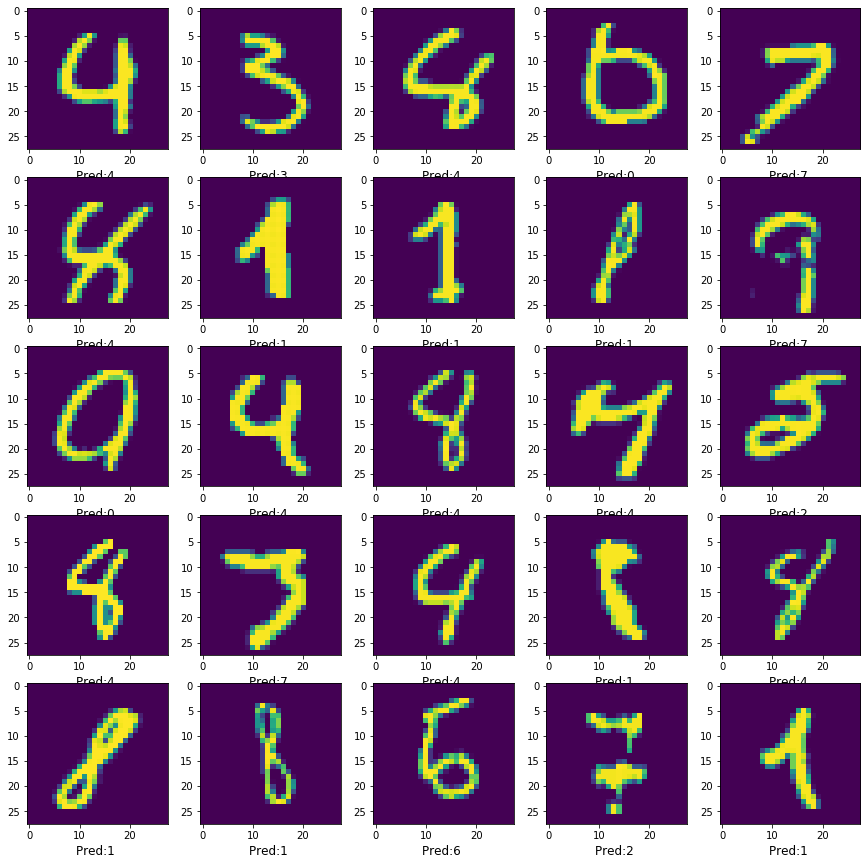

In [13]:
# L1 wrong image predictions
columns = 5
rows = 5 
fig=plt.figure(figsize=(15, 15))
for i in range(1, columns*rows +1):
    img = misclassified_list_l1[i-1][0].cpu().numpy()[0]
    fig.add_subplot(rows, columns, i)
    # plt.axis('off')
    xlabel = "Pred:{} ".format(misclassified_list_l1[i-1][1])
    # print(xlabel)
    plt.xlabel(xlabel, fontsize=12)
    plt.imshow(img)

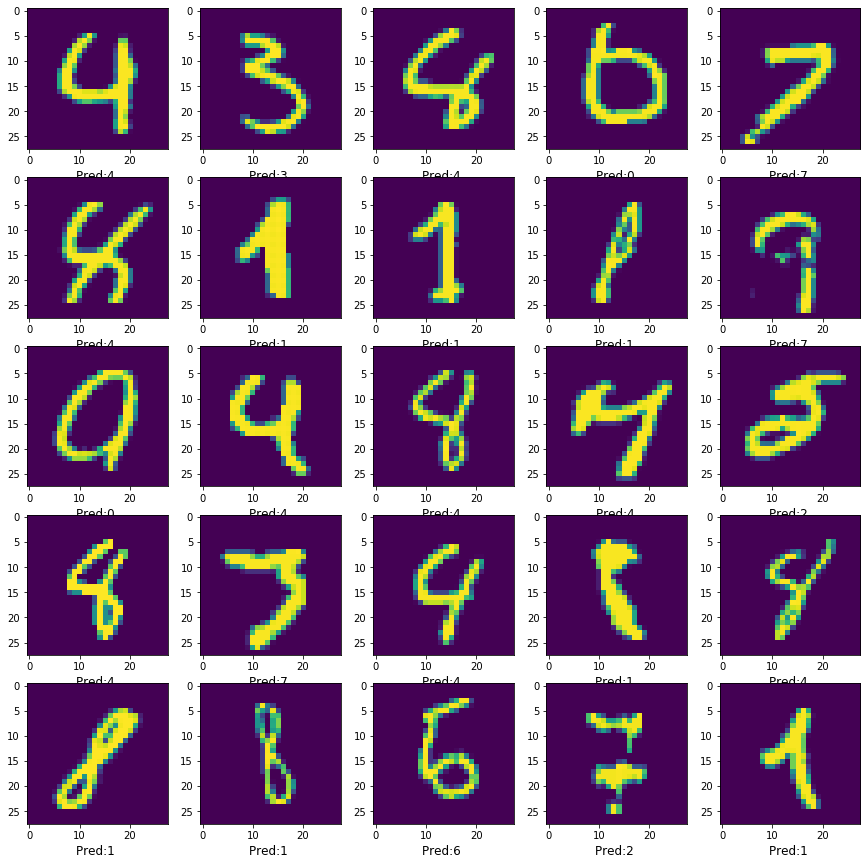

In [14]:
# L2 wrong image predictions
columns = 5
rows = 5 
fig=plt.figure(figsize=(15, 15))
for i in range(1, columns*rows +1):
    img = misclassified_list_l1[i-1][0].cpu().numpy()[0]
    fig.add_subplot(rows, columns, i)
    # plt.axis('off')
    xlabel = "Pred:{} ".format(misclassified_list_l1[i-1][1])
    # print(xlabel)
    plt.xlabel(xlabel, fontsize=12)
    plt.imshow(img)

Text(0.5, 1.0, 'Test Loss vs Epochs')

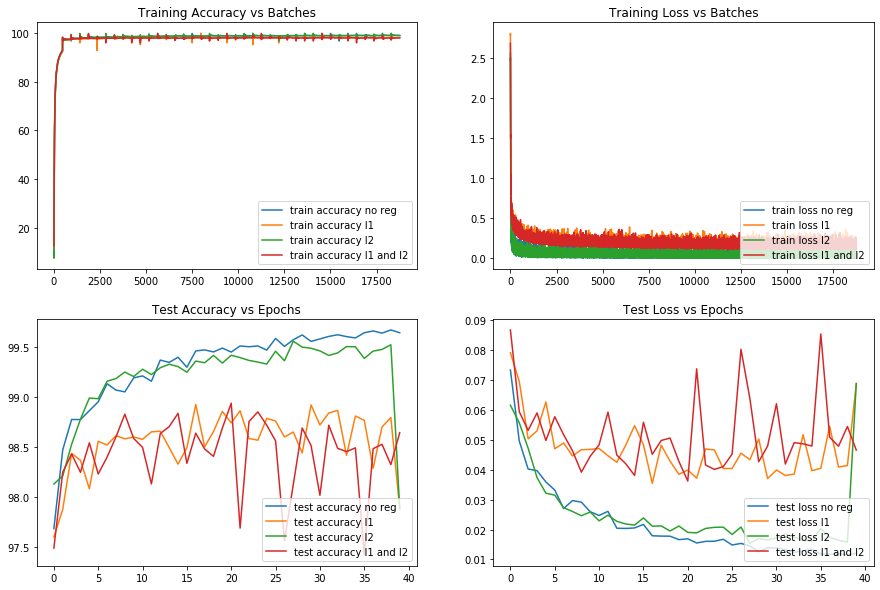

In [15]:
# graphs
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_acc_no_reg, label = "train accuracy no reg")
axs[0, 0].plot(train_acc_l1, label = "train accuracy l1")
axs[0, 0].plot(train_acc_l2, label = "train accuracy l2")
axs[0, 0].plot(train_acc_l1_l2, label = "train accuracy l1 and l2")
axs[0, 0].legend(loc="lower right")
axs[0, 0].set_title("Training Accuracy vs Batches")

axs[0, 1].plot(train_losses_no_reg, label = "train loss no reg")
axs[0, 1].plot(train_losses_l1, label = "train loss l1")
axs[0, 1].plot(train_losses_l2, label = "train loss l2")
axs[0, 1].plot(train_losses_l1_l2, label = "train loss l1 and l2")
axs[0, 1].legend(loc="lower right")
axs[0, 1].set_title("Training Loss vs Batches")

axs[1, 0].plot(test_acc_no_reg, label = "test accuracy no reg")
axs[1, 0].plot(test_acc_l1, label = "test accuracy l1")
axs[1, 0].plot(test_acc_l2, label = "test accuracy l2")
axs[1, 0].plot(test_acc_l1_l2, label = "test accuracy l1 and l2")
axs[1, 0].legend(loc="lower right")
axs[1, 0].set_title("Test Accuracy vs Epochs")

axs[1, 1].plot(test_losses_no_reg, label = "test loss no reg")
axs[1, 1].plot(test_losses_l1, label = "test loss l1")
axs[1, 1].plot(test_losses_l2, label = "test loss l2")
axs[1, 1].plot(test_losses_l1_l2, label = "test loss l1 and l2")
axs[1, 1].legend(loc="lower right")
axs[1, 1].set_title("Test Loss vs Epochs")
